In [1]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

In [2]:
#import findspark
#findspark.init()
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Spark Intro") \
    .getOrCreate()

sc = spark.sparkContext

In [10]:
spark

## Answer 1.A ##

In [11]:
# importing libraries
import pyspark.sql.functions as f
from pyspark.sql.functions import *

# reading data
logFile = spark.read.text('Data/NASA_access_log_Jul95.gz')
logFile.show(5, False)


+-----------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                  |
+-----------------------------------------------------------------------------------------------------------------------+
|199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245                                 |
|unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985                      |
|199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085   |
|burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0               |
|199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179|
+-----------------------

In [4]:
# split operations
split_col = f.split(logFile['value'], ' ')
logFile1 = logFile.withColumn('host', split_col.getItem(0))
logFile2 = logFile1.withColumn('a', split_col.getItem(1))
logFile3 = logFile2.withColumn('b', split_col.getItem(2))
logFile4 = logFile3.withColumn('timestamp', split_col.getItem(3))
logFile5 = logFile4.withColumn('c', split_col.getItem(4))
logFile6 = logFile5.withColumn('get', split_col.getItem(5))
logFile7 = logFile6.withColumn('request', split_col.getItem(6))
logFile8 = logFile7.withColumn('total', split_col.getItem(7))
logFile9 = logFile8.withColumn('HTTP', split_col.getItem(8))
logFile10 = logFile9.withColumn('bytes', split_col.getItem(9))

In [7]:
# table modification
d_time = logFile10.drop('value', 'a', 'b', 'total')
spcl = f.split(d_time['timestamp'], ':')
d_time = d_time.withColumn('timestamp', spcl.getItem(0))
d_time_new = d_time.select('timestamp')
ime = f.split(d_time_new['timestamp'], '\[')
d_time_new = d_time_new.withColumn('timestamp', ime.getItem(1))
changed_d_time = d_time_new.withColumn('updatedtimestamp', regexp_replace('timestamp','/Jul/','-07-'))
changed_d_time = changed_d_time.drop('timestamp')
changed_d_time = changed_d_time.withColumn('dateformat', to_date('updatedtimestamp', 'dd-MM-yyyy'))
changed_d_time = changed_d_time.withColumn('days', date_format('dateformat','E'))
days_name = changed_d_time.groupBy('days').count()
days_name = days_name.where(days_name.days.isNotNull()) # removing null
days_name.show()

+----+------+
|days| count|
+----+------+
| Sun|182590|
| Mon|301684|
| Thu|363436|
| Sat|184380|
| Wed|318698|
| Tue|277840|
| Fri|263086|
+----+------+



In [8]:
d_time.select('request').count()

1891715

In [12]:
# Dividing each by 4 as the total number of unique days is 4
avg_sun = 182590/4
avg_mon = 301684/4
avg_thu = 363436/4
avg_sat = 184380/4
avg_wed = 318698/4
avg_tue = 277840/4
avg_fri = 263086/4
print('The average number of requests on Sunday is', avg_sun)
print('The average number of requests on Monday is', avg_mon)
print('The average number of requests on Tuesday is', avg_tue)
print('The average number of requests on Wednesday is', avg_wed)
print('The average number of requests on Thursday is', avg_thu)
print('The average number of requests on Friday is', avg_fri)
print('The average number of requests on Saturday is', avg_sat)

The average number of requests on Sunday is 45647.5
The average number of requests on Monday is 75421.0
The average number of requests on Tuesday is 69460.0
The average number of requests on Wednesday is 79674.5
The average number of requests on Thursday is 90859.0
The average number of requests on Friday is 65771.5
The average number of requests on Saturday is 46095.0


## Answer 1.B ##

In [32]:
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

Text(0.5, 1.0, 'Average Requests on Each Day')

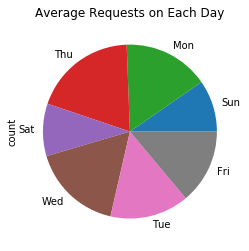

In [36]:
# plot the values
pie_dates = days_name.toPandas()
pie_dates.plot(kind = 'pie', y = 'count', labels = pie_dates['days'], legend = False)
plt.title('Average Requests on Each Day')

## Answer 1.C ##

In [37]:
# finding count of top 20 requests
website = d_time.select('request')
website = website.filter(website.request.contains(".gif"))
website = website.groupBy('request').count()
web = website.orderBy('count', ascending = False)
web.show(20, False)

+---------------------------------------------------+------+
|request                                            |count |
+---------------------------------------------------+------+
|/images/NASA-logosmall.gif                         |111144|
|/images/KSC-logosmall.gif                          |89530 |
|/images/MOSAIC-logosmall.gif                       |60300 |
|/images/USA-logosmall.gif                          |59845 |
|/images/WORLD-logosmall.gif                        |59325 |
|/images/ksclogo-medium.gif                         |58616 |
|/images/launch-logo.gif                            |40841 |
|/images/ksclogosmall.gif                           |33555 |
|/history/apollo/images/apollo-logo1.gif            |31052 |
|/shuttle/countdown/count.gif                       |22189 |
|/shuttle/countdown/count70.gif                     |20921 |
|/images/launchmedium.gif                           |20788 |
|/shuttle/missions/sts-71/sts-71-patch-small.gif    |19832 |
|/shuttle/missions/sts-7

## Answer 1.D ##

Text(0.5, 1.0, 'Top 20 Most Requested .gif Images')

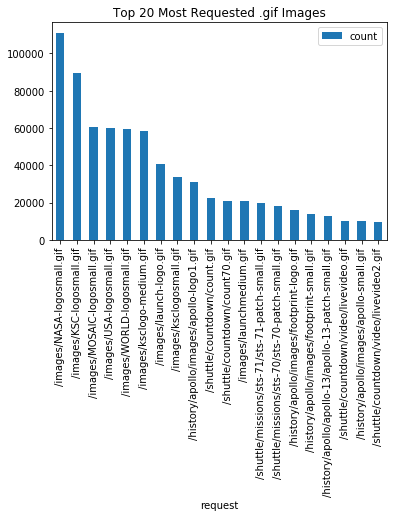

In [43]:
# plotting the values
gif_bar = web.limit(20).toPandas()
gif_bar.plot(kind = 'bar', y = 'count', x = 'request', legend = True)
plt.title('Top 20 Most Requested .gif Images')

## Answer 2.A ##

In [44]:
# importing libraries
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import numpy as np

In [45]:
# loading data
ratings = spark.read.load("Data/ml-20m/ratings.csv",format="csv", inferSchema="true", header="true")

In [46]:
ratings.show(5, False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |2      |3.5   |1112486027|
|1     |29     |3.5   |1112484676|
|1     |32     |3.5   |1112484819|
|1     |47     |3.5   |1112484727|
|1     |50     |3.5   |1112484580|
+------+-------+------+----------+
only showing top 5 rows



In [47]:
# splitting the data in to 5 parts
ratings_split = ratings.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2])
ratings_split

[DataFrame[userId: int, movieId: int, rating: double, timestamp: int],
 DataFrame[userId: int, movieId: int, rating: double, timestamp: int],
 DataFrame[userId: int, movieId: int, rating: double, timestamp: int],
 DataFrame[userId: int, movieId: int, rating: double, timestamp: int],
 DataFrame[userId: int, movieId: int, rating: double, timestamp: int]]

In [48]:
# ALS operation
k = 5
rmse_5_drop = []
rmse_5_reg = []
mae_5_drop = []
mae_5_reg = []
ifac = []

# looping over data to implement k-fold
for i in range(0, k):
    training = None
    for j in range(1, k):
        if i == j:
            continue
        if training == None:
            training = ratings_split[j]
        else:
            training = training.union(ratings_split[j])
    print('Iteration' + str(i+1))
    testing = ratings_split[i]        
    als_drop = ALS(maxIter=10, rank = 1, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
    als_reg = ALS(maxIter=5, rank = 1, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
    model_drop = als_drop.fit(training)
    model_reg = als_reg.fit(training)
    ifac.append(model_drop.itemFactors)
    predictions_drop = model_drop.transform(testing)
    predictions_reg = model_reg.transform(testing)
    evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")
    rmse_drop = evaluator_rmse.evaluate(predictions_drop)
    rmse_reg = evaluator_rmse.evaluate(predictions_reg)
    mae_drop = evaluator_mae.evaluate(predictions_drop)
    mae_reg = evaluator_mae.evaluate(predictions_reg)
    
    rmse_5_drop.append(rmse_drop)
    rmse_5_reg.append(rmse_reg)
    mae_5_drop.append(mae_drop)
    mae_5_reg.append(mae_reg)
    

print("Root-mean-square error for Drop = ")
print(rmse_5_drop)

print("Root-mean-square error for reg = ")
print(rmse_5_reg)

print("Mean-average error for Drop = ")
print(mae_5_drop)

print("Mean-average error for reg = ")
print(mae_5_reg)

Iteration1
Iteration2
Iteration3
Iteration4
Iteration5
Root-mean-square error for Drop = 
[0.8643843534413855, 0.8655667434886545, 0.8659394951061191, 0.8662702856353186, 0.8662523873215012]
Root-mean-square error for reg = 
[0.8632276067748995, 0.864425908550884, 0.8647671723737859, 0.8651279928590947, 0.8651229181013846]
Mean-average error for Drop = 
[0.6689303164378689, 0.6698214442265666, 0.6701502740246369, 0.6704782775716464, 0.6703724097900341]
Mean-average error for reg = 
[0.6663492897354671, 0.6673315209193306, 0.6676059291303929, 0.6679872957909944, 0.6678914388662792]


In [49]:
# calculating values
rmse_5_avg_drop = np.mean(rmse_5_drop)
mae_5_avg_drop = np.mean(mae_5_drop)
rmse_5_avg_reg = np.mean(rmse_5_reg)
mae_5_avg_reg = np.mean(mae_5_reg)
print('Average RMSE for 1st case is ' + str(rmse_5_avg_drop))
print('Average MAE for 1st case is ' + str(mae_5_avg_drop))
print('Average RMSE for 2nd case is ' + str(rmse_5_avg_reg))
print('Average MAE for 2nd case is ' + str(mae_5_avg_reg))

Average RMSE for 1st case is 0.865682652999
Average MAE for 1st case is 0.66995054441
Average RMSE for 2nd case is 0.864534319732
Average MAE for 2nd case is 0.667433094888


In [50]:
rmse_5_std_drop = np.std(rmse_5_drop)
mae_5_std_drop = np.std(mae_5_drop)
rmse_5_std_reg = np.std(rmse_5_reg)
mae_5_std_reg = np.std(mae_5_reg)
print('RMSE Standard deviation for 1st case is ' + str(rmse_5_std_drop))
print('MAE Standard deviation for 1st case is ' + str(mae_5_std_drop))
print('RMSE Standard deviation for 2nd case is ' + str(rmse_5_std_reg))
print('MAE Standard deviation for 2nd case is ' + str(mae_5_std_reg))

RMSE Standard deviation for 1st case is 0.00069783865433
MAE Standard deviation for 1st case is 0.000557475843462
RMSE Standard deviation for 2nd case is 0.000703188155689
MAE Standard deviation for 2nd case is 0.000588564422713


## Answer 2.C ##

In [51]:
import pyspark.sql.functions as f
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import ClusteringEvaluator

In [52]:
genome_scores = spark.read.load("Data/ml-20m/genome-scores.csv",format="csv", inferSchema="true", header="true")
genome_tags = spark.read.load("Data/ml-20m/genome-tags.csv",format="csv", inferSchema="true", header="true")

In [53]:
# implementing UDF for dense vectors
dense_vectors = f.udf(lambda r : Vectors.dense(r),VectorUDT())
list_of_movies = []
# k-means implementation
for cluster in range(len(ifac)):
    # dataframe generation
    data_frame_1 = ifac[cluster].withColumn("densevectors",dense_vectors("features"))
    data_frame_2 = data_frame_1.drop("features")
    data_frame_3 = data_frame_2.selectExpr("id as id" , "densevectors as features")
    kmeans = KMeans().setK(20).setSeed(1)
    model = kmeans.fit(data_frame_3)
    predictions = model.transform(data_frame_3)
    trans = predictions.groupBy("prediction").count()
    transformed = trans.orderBy("count", ascending = False).limit(3)
    top_transform = transformed.collect()
    top_three = []
    list_of_ids = []
    for top in top_transform:
        top_three.append(top.prediction)
    for each in range(3):
        id_clusters = predictions.filter(predictions.prediction == top_three[each])
        collectids = id_clusters.collect()
        id_clus = []
        for row in collectids:
            id_clus.append(row.id)
        list_of_ids.append(id_clus)
    list_of_movies.append(list_of_ids)    

In [54]:
for each in list_of_movies:
    for cluster in each:
        add_movie = list_of_movies.index(each)+1
        print('Split : ' + str(add_movie))
        add_cluster = each.index(cluster)+1
        print('Cluster : ' + str(add_cluster))
        mov = genome_scores.where(genome_scores.movieId.isin(cluster))
        tags = mov.groupBy("tagId").agg(f.sum("relevance"))
        top = tags.orderBy("sum(relevance)", ascending = False).limit(5)
        top_five = top.collect()
        list_of_tags = []
        for five in top_five:
              list_of_tags.append(five.tagId)
        genome_tags.where(genome_tags.tagId.isin(list_of_tags)).show(5)             

Split : 1
Cluster : 1
+-----+------------+
|tagId|         tag|
+-----+------------+
|  188| catastrophe|
|  302|    dialogue|
|  468|great ending|
|  646|      mentor|
|  742|    original|
+-----+------------+

Split : 1
Cluster : 2
+-----+------------+
|tagId|         tag|
+-----+------------+
|  188| catastrophe|
|  302|    dialogue|
|  468|great ending|
|  646|      mentor|
|  742|    original|
+-----+------------+

Split : 1
Cluster : 3
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  302|       dialogue|
|  452|good soundtrack|
|  468|   great ending|
|  646|         mentor|
|  742|       original|
+-----+---------------+

Split : 2
Cluster : 1
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  302|       dialogue|
|  452|good soundtrack|
|  468|   great ending|
|  646|         mentor|
|  742|       original|
+-----+---------------+

Split : 2
Cluster : 2
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  3